In [2]:
from astroquery.sdss import SDSS
from astropy.table import Table
import pandas as pd
import numpy as np
# astronomy things
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle 
import astropy.units as u
from astropy.wcs import WCS
from astropy.stats import sigma_clip
from astropy.visualization import MinMaxInterval, SqrtStretch, ImageNormalize, ZScaleInterval, LogStretch, LinearStretch, SinhStretch, AsinhStretch, make_lupton_rgb

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.optimize import curve_fit

from photutils.centroids import centroid_sources


In [9]:
def sigmoid(x):
    """
    uses sigmoid function to scale while perserving relative distance
    """
    return (1 / (1 + np.e**(-x)))


def gaussian_2d(xy, A, mu_x, sig_x, mu_y, sig_y, theta, offset):
    x, y = xy
    a = (   np.cos(theta) ** 2 )   / (2 * sig_x ** 2) + (np.sin(theta) ** 2) / (2 * sig_y ** 2)
    b = (  -np.sin(2*theta)    )   / (4 * sig_x ** 2) + (np.sin(2*theta)   ) / (4 * sig_y ** 2)
    c = (   np.sin(theta) ** 2 )   / (2 * sig_x ** 2) + (np.cos(theta) ** 2) / (2 * sig_y ** 2)
    g =  offset + A * np.exp( -1 * ( a * (x - mu_x) ** 2  + 2 * b * (x - mu_x)*(y - mu_y) + c * (y - mu_y) ** 2 ))
    return g.ravel()
    
    

In [10]:
df = pd.read_csv("data/star_classification.csv")
bands = ['u', 'g', 'r', 'i', 'z']



In [38]:
def fit_2d_gaussian(chip_data, object, band, ax):
    center_chip_x, center_chip_y = chip_data.shape[1] / 2, chip_data.shape[0] / 2
    
    
    try:
        # fit a 2-d gaussian to get a sigma for 99% of the object
        x_fit = np.arange(0, chip_data.shape[0])
        y_fit = np.arange(0, chip_data.shape[0])
        x_fit, y_fit = np.meshgrid(x_fit, y_fit)
        initial_guess = (1, center_chip_x, 1, center_chip_y, 1, 0, 0)
        popt, pcov = curve_fit(gaussian_2d, (x_fit, y_fit), chip_data.ravel(), p0=initial_guess)
        A, mu_x, sig_x, mu_y, sig_y, theta, offset = popt
        theta_deg = 180 / np.pi * theta
        
        
        # add a gaussian 
        n_sig = 6
        ellipse = patches.Ellipse((mu_x, mu_y), sig_y * n_sig, sig_x * n_sig, theta_deg, fill=False, color='red')
        ax.add_patch(ellipse)
        ax.set_title(f"Raw {object.name} - {band} -\n {mu_x:.3f} ")
            
        return ax
    except Exception as e:
        return ax
        

idx = 205	 GALAXY


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
C:\Users\hbar6\AppData\Local\Temp\ipykernel_13216\742526877.py:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = patches.Ellipse((mu_x, mu_y), sig_y * n_sig, sig_x * n_sig, theta_deg, fill=False, color='red')
c:\Users\hbar6\projects\MIDS\207\Stellar-Classification\.venv\lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\hbar6\AppData\Local\Temp\ipykernel_13216\742526877.py:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = patches.Ellipse((mu_x, mu_y), sig_y * n_sig, sig_x * n_sig, thet

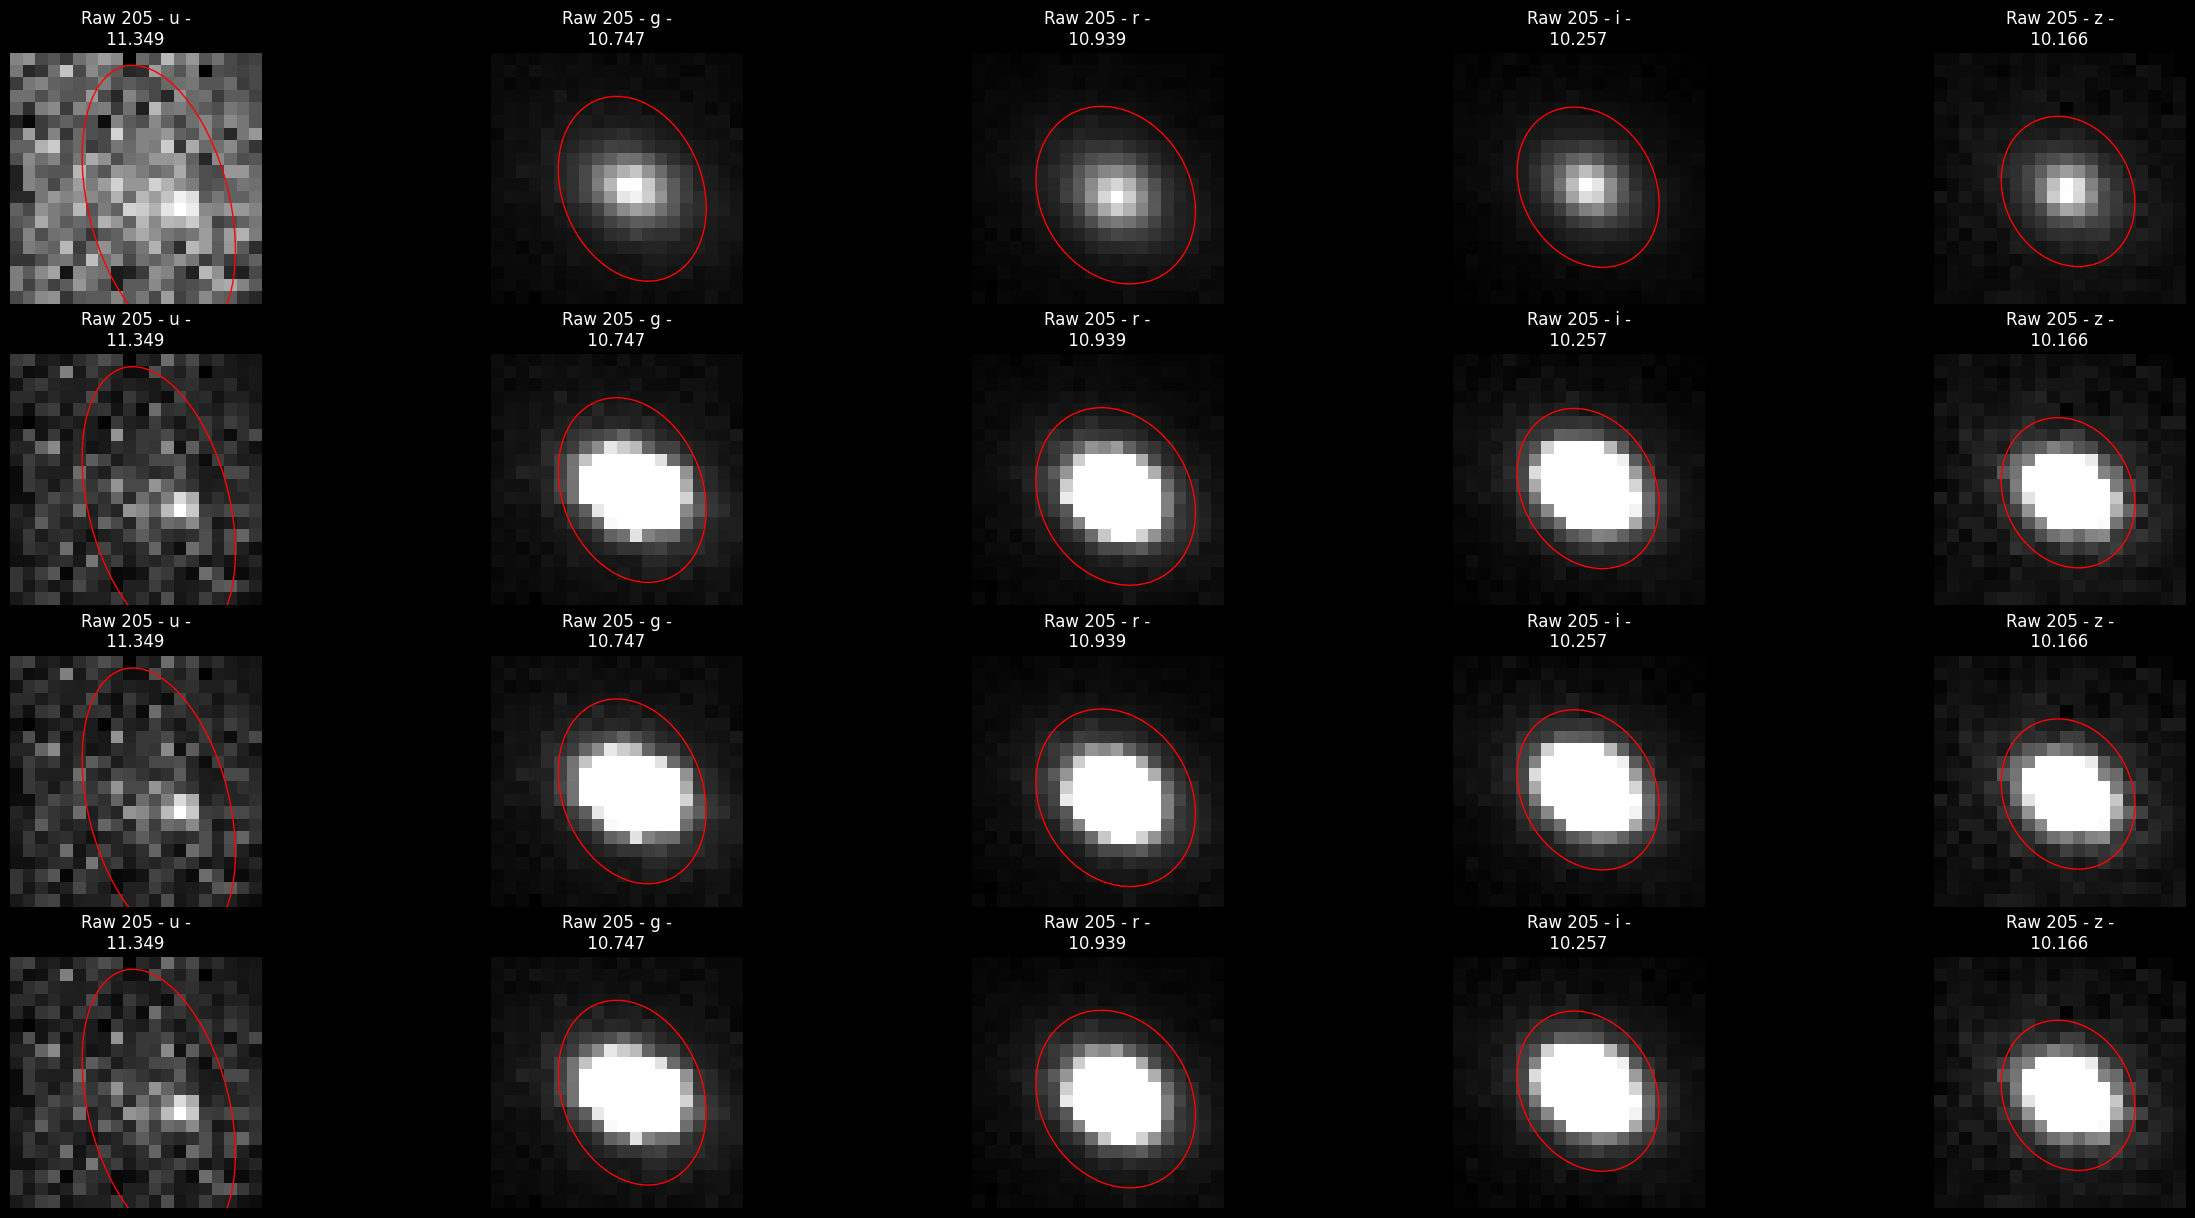

In [39]:
fig,ax = plt.subplots(4,5)
fig.set_size_inches(30,15)


idx = np.random.randint(0,100_000)

# idx = 1
# idx = 68181	 	 	 	
 
object = df.iloc[idx]
print(f"idx = {idx}\t {object['class']}")
run_id = object['run_ID']
rerun_id = object['rerun_ID']
cam_col = object['cam_col']
field_id = object['field_ID']
spec_obj_id = object['spec_obj_ID']

# get coordinates of object RA/DEC
ra = Angle(object['alpha'], unit=u.deg)
dec = Angle(object['delta'], unit=u.deg)
c = SkyCoord(ra, dec, frame='icrs')

xids_table = SDSS.query_region(c) # this can return multiple items
xids = xids_table.to_pandas()
xids = xids.query(f"run == {run_id} and rerun == {rerun_id} and camcol == {cam_col} and field == {field_id}")
xids["distance_from_object"] = np.sqrt((xids['ra'] - ra)**2 + (xids['dec'] - dec)**2)
best_plate = xids[xids['distance_from_object'] == xids['distance_from_object'].min()]

best_plate = Table.from_pandas(best_plate.drop("distance_from_object", axis=1))

# LOOP OVER ALL IMAGES HERE

img_data_buffer = [SDSS.get_images(matches=best_plate, band = band) for band in bands]
for idx, (img, band) in enumerate(zip(img_data_buffer,bands)):
    header = img[0][0].header
    wcs = WCS(header)
    obj_pix_x, obj_pix_y = wcs.world_to_pixel(c)

    chip_size = 10
    slice_y_0, slice_y_1 = int(obj_pix_y-chip_size), int(obj_pix_y+chip_size)
    slice_x_0, slice_x_1 = int(obj_pix_x-chip_size), int(obj_pix_x+chip_size)
    # slice_y_0, slice_y_1 = 0, -1
    # slice_x_0, slice_x_1 = 0, -1
    
    
    img_data = img[0][0].data.copy()

    # make initial large chip of the object we are interested in
    chip_data = img_data[slice_y_0:slice_y_1, slice_x_0:slice_x_1]
    center_chip_x, center_chip_y = chip_data.shape[1] / 2, chip_data.shape[0] / 2


    
    # plotting
    ax[0,idx].imshow(chip_data, cmap='gray')
    ax[0,idx].axis('off')
    ax[0,idx] = fit_2d_gaussian(chip_data, object, band, ax[0, idx])
    
    
    
    
    
    
    
    
    # no noise reduction, no background subtraction
    # make chips of the object we are interested in
    chip_data = img_data[slice_y_0:slice_y_1, slice_x_0:slice_x_1]
    interval = ZScaleInterval(max_iterations=10)
    vmin, vmax = interval.get_limits(chip_data)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SinhStretch())

    # plotting
    ax[1,idx].imshow(chip_data, cmap='gray', norm=norm)
    ax[1,idx].axis('off')
    ax[1,idx] = fit_2d_gaussian(chip_data, object, band, ax[1, idx])
    
    
    
    
    # try with noise and background subtraction
    noise = np.std(img_data)
    background = np.median(img_data)
    cleaned_img_data = (img_data - background) / noise

    # chips
    chip_data = cleaned_img_data[slice_y_0:slice_y_1, slice_x_0:slice_x_1]
    interval = ZScaleInterval(max_iterations=10)
    vmin, vmax = interval.get_limits(chip_data)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SinhStretch())

    # plotting
    ax[2,idx].imshow(chip_data, cmap='gray', norm=norm)
    ax[2,idx].axis('off')
    ax[2,idx] = fit_2d_gaussian(chip_data, object, band, ax[2, idx])
    
    
    
    
    
    
    # sigma clipped stats
    clipped_data = sigma_clip(img_data)
    median = np.median(clipped_data) # bias
    std = np.std(clipped_data) # noise
    sigma_cleaned_img_data = (img_data - median) / std
    
    # chips
    chip_data = sigma_cleaned_img_data[slice_y_0:slice_y_1, slice_x_0:slice_x_1]
    interval = ZScaleInterval(max_iterations=10)
    vmin, vmax = interval.get_limits(chip_data)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SinhStretch())

    # plotting
    ax[3,idx].imshow(chip_data, cmap='gray', norm=norm)
    ax[3,idx].axis('off')
    ax[3, idx] = fit_2d_gaussian(chip_data, object, band, ax[3, idx])
    
    





In [5]:
# fig.savefig("./media/first_comparison.png", dpi=1000, bbox_inches='tight')